In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time

from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Subset

from datasets import SurfaceDataset, InferenceDataset
from helpers import EarlyStopper
from models import CNNSurfaceClassifier

from torchinfo import summary

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
BATCH_SIZE = 32
INPUT_SIZE = 8
NUM_EPOCHS = 100
DATA_DIR = Path('../data/dataset/')
HISTORY_DIR = Path('../results/tuning/')
LOOKBACK = 2.
SAMPLING_FREQUENCY = 100.
DATASET_FREQUENCY = 200.
SUBSET = ('imu', 'servo')
CONFIGURATIONS = ('4W',)

In [4]:
cnn_model = CNNSurfaceClassifier(input_size=INPUT_SIZE, output_size=10).to(device)
cnn_model.load_state_dict(torch.load('../data/checkpoints/cnn_classifier_imu_servo_4W_2024-05-08-22-15-06.pt')['model_state_dict'])
# cnn_model.load_state_dict(torch.load('../data/checkpoints/cnn_classifier_imu_4W_2024-05-09-08-24-17.pt'))
cnn_model.eval()

CNNSurfaceClassifier(
  (conv_pre): Sequential(
    (0): Conv1d(8, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): Block(
    (mapping): Conv1d(32, 64, kernel_size=(1,), stride=(2,))
    (bblock1): BasicBlock(
      (conv): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (bblock2): BasicBlock(
      (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
  )
  (block2): Block(
    (mapping): Conv1d(64, 128, kernel_size=(1,), stride=(2,))
    (bblock1): BasicBlock(
      (conv): Conv1d(64, 128, kernel_size=(3,), stride=(2,

In [41]:
file1 = '../data/test_set/csv/07-05-4-kola-3-podloza-25-cm_CCW_3.csv'
file2 = '../data/train_set/csv/gray_23_2023-07-13-18-27-45.csv'

In [42]:
dataset = InferenceDataset(file2, sample_freq=SAMPLING_FREQUENCY, data_freq=DATASET_FREQUENCY, lookback=LOOKBACK, subset=SUBSET)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [43]:
batches = len(dataloader)
y_pred = []

pbar = tqdm(dataloader, total=batches)
cnn_model.eval()
with torch.no_grad():
    for idx, batch_x in enumerate(pbar):
        batch_x = batch_x.to(device)
        batch_x = batch_x.permute(0, 2, 1)
        outputs = cnn_model(batch_x)
        
        # y_true.extend(torch.argmax(batch_y, dim=1).cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

100%|██████████| 157/157 [00:00<00:00, 213.92it/s]


(0.0, 9.0)

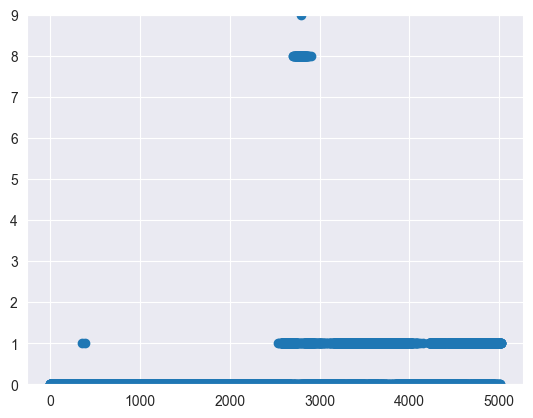

In [44]:
plt.scatter(x=range(len(y_pred)), y=y_pred)
plt.ylim(0, 9)